# Setup

In [1]:
# import libraries
import os
import sys
import time
import pandas as pd
import numpy as np
from scipy import stats
from scipy.interpolate import CubicSpline
import torch.optim as optim
import torch.nn as nn
import torch
from torch.optim import Adam
from scipy.fftpack import fft, ifft
from scipy.stats import mode

## Hyperparameter

In [2]:
num_epochs = 200
batch_size = 64  # Set your batch size
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# set the seed
torch.manual_seed(420)
np.random.seed(420)


# Data Loading

## HHAR

In [4]:
# load data
# data = pd.read_csv('./ISWC21_data_plus_raw/hhar_data.csv', header=None)
data_hhar = pd.read_csv('./ISWC21_data_plus_raw/raw/hhar/Watch_accelerometer.csv')
#add header
# data.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']

# sort data by creation_time
data_hhar = data_hhar.sort_values(by=['Creation_Time'])
data_hhar

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
3179488,0,1424686740286,202601646000,4.018668,-7.155670,-3.341109,g,gear,gear_2,stand
3179489,1,1424686740287,202609390000,3.605069,-6.991668,-3.151368,g,gear,gear_2,stand
3179490,2,1424686740287,202619269000,3.038841,-6.546346,-3.436278,g,gear,gear_2,stand
3179491,3,1424686740287,202631619000,3.030461,-6.183026,-2.860472,g,gear,gear_2,stand
3179492,4,1424686740287,202639113000,3.354875,-6.126762,-2.382231,g,gear,gear_2,stand
...,...,...,...,...,...,...,...,...,...,...
2457915,459441,1424789460608,300643618732647,7.858872,3.448090,7.490219,e,lgwatch,lgwatch_1,bike
2457916,459442,1424789460612,300643623676495,7.478012,3.455231,6.997482,e,lgwatch,lgwatch_1,bike
2457917,459443,1424789460618,300643628711895,7.516098,2.324554,6.661850,e,lgwatch,lgwatch_1,bike
2457918,459444,1424789460622,300643633625225,6.811508,2.072235,6.885605,e,lgwatch,lgwatch_1,bike


In [5]:
# print number of unique subjects
print(data_hhar['User'].nunique())

9


### Data Preprocessed

In [6]:
# drop columns
data_hhar = data_hhar.drop(columns=['Index', 'Arrival_Time', 'Creation_Time', 'Model', 'Device'])
data_hhar

,x,y,z,User,gt
3179488,4.018668,-7.155670,-3.341109,g,stand
3179489,3.605069,-6.991668,-3.151368,g,stand
3179490,3.038841,-6.546346,-3.436278,g,stand
3179491,3.030461,-6.183026,-2.860472,g,stand
3179492,3.354875,-6.126762,-2.382231,g,stand
...,...,...,...,...,...
2457915,7.858872,3.448090,7.490219,e,bike
2457916,7.478012,3.455231,6.997482,e,bike
2457917,7.516098,2.324554,6.661850,e,bike
2457918,6.811508,2.072235,6.885605,e,bike


In [7]:
# replace user id with a number
user_dict = {
        'a': 0,
        'b': 1,
        'c': 2,
        'd': 3,
        'e': 4,
        'f': 5,
        'g': 6,
        'h': 7,
        'i': 8,
}
data_hhar = data_hhar.replace({"User": user_dict})

In [8]:
# replace activity with a number
activity_dict = {
        'bike': 1,
        'sit': 2,
        'stand': 3,
        'walk': 4,
        'stairsup': 5,
        'stairsdown': 6,
}
data_hhar = data_hhar.replace({"gt": activity_dict})

In [9]:
# print(data_hhar['gt'].value_counts())

In [10]:
# print(data_hhar['User'].value_counts())

In [11]:
data_hhar

,x,y,z,User,gt
3179488,4.018668,-7.155670,-3.341109,6,3.0
3179489,3.605069,-6.991668,-3.151368,6,3.0
3179490,3.038841,-6.546346,-3.436278,6,3.0
3179491,3.030461,-6.183026,-2.860472,6,3.0
3179492,3.354875,-6.126762,-2.382231,6,3.0
...,...,...,...,...,...
2457915,7.858872,3.448090,7.490219,4,1.0
2457916,7.478012,3.455231,6.997482,4,1.0
2457917,7.516098,2.324554,6.661850,4,1.0
2457918,6.811508,2.072235,6.885605,4,1.0


In [12]:
# resample data to 50 hz from 100 hz
data_hhar = data_hhar.iloc[::2, :]

In [13]:
# reorder columns
data_hhar = data_hhar[['User', 'x', 'y', 'z', 'gt']]

In [14]:
# rename the columns name
data_hhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']

In [15]:
data_hhar

,subject_id,acc_x,acc_y,acc_z,activity
3179488,6,4.018668,-7.155670,-3.341109,3.0
3179490,6,3.038841,-6.546346,-3.436278,3.0
3179492,6,3.354875,-6.126762,-2.382231,3.0
3179494,6,2.688689,-5.518635,-1.930924,3.0
3179498,6,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
2457910,4,6.751999,1.558075,7.064133,1.0
2457912,4,7.835068,2.555450,8.770859,1.0
2457914,4,8.118332,3.052948,8.444748,1.0
2457916,4,7.478012,3.455231,6.997482,1.0


In [16]:
# check for missing values
data_hhar.isnull().sum()

subject_id         0
acc_x              0
acc_y              0
acc_z              0
activity      260235
dtype: int64

In [17]:
# drop missing values
data_hhar = data_hhar.dropna()

In [18]:
print(data_hhar['subject_id'].unique())

[6 5 7 3 2 1 0 4 8]


## RealWorld

In [19]:
# load data without header
data_rwhar = pd.read_csv('./ISWC21_data_plus_raw/rwhar_data.csv', header=None)
# add header
data_rwhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']
data_rwhar

,subject_id,acc_x,acc_y,acc_z,activity
0,0,-9.57434,-2.02733,1.34506,climbing_up
1,0,-9.56479,-1.99597,1.39345,climbing_up
2,0,-9.55122,-1.98445,1.41139,climbing_up
3,0,-9.51335,-1.97557,1.42615,climbing_up
4,0,-9.52959,-1.98187,1.45395,climbing_up
...,...,...,...,...,...
3200798,14,-9.28186,-2.45740,-1.88879,lying
3200799,14,-9.28955,-2.59154,-1.90494,lying
3200800,14,-9.31358,-2.62135,-1.90950,lying
3200801,14,-9.26154,-2.64308,-1.93750,lying


In [20]:
# print count of unique subjects
print(data_rwhar['subject_id'].nunique())

15


In [21]:
# print count of unique activities
print(data_rwhar['activity'].nunique())

8


### Data Preprocessed

In [22]:
#check for missing values
data_rwhar.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [23]:
data_rwhar['subject_id'] = data_rwhar['subject_id'] + 9

In [24]:
print(data_rwhar['subject_id'].unique())

[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [25]:
# replace activity with a number
activity_dict = {
        'climbing_down': 6,
        'climbing_up': 5,
        'jumping': 7,
        'lying': 8,
        'running': 9,
        'sitting': 2,
        'standing': 3,
        'walking': 4,
}
data_rwhar = data_rwhar.replace({"activity": activity_dict})

In [26]:
print(data_rwhar['activity'].value_counts())

activity
9    522013
4    482938
8    479455
2    478761
3    473147
5    371180
6    320302
7     73007
Name: count, dtype: int64


In [27]:
print(data_rwhar['subject_id'].value_counts())

subject_id
13    245822
16    243823
11    227821
17    224449
23    222116
19    220262
21    218636
14    215920
9     214659
20    212453
18    210260
12    207492
15    189243
22    179282
10    168565
Name: count, dtype: int64


In [28]:
data_rwhar

,subject_id,acc_x,acc_y,acc_z,activity
0,9,-9.57434,-2.02733,1.34506,5
1,9,-9.56479,-1.99597,1.39345,5
2,9,-9.55122,-1.98445,1.41139,5
3,9,-9.51335,-1.97557,1.42615,5
4,9,-9.52959,-1.98187,1.45395,5
...,...,...,...,...,...
3200798,23,-9.28186,-2.45740,-1.88879,8
3200799,23,-9.28955,-2.59154,-1.90494,8
3200800,23,-9.31358,-2.62135,-1.90950,8
3200801,23,-9.26154,-2.64308,-1.93750,8


## SBHAR

In [29]:
#load dataset without header
data_sbhar = pd.read_csv('./ISWC21_data_plus_raw/sbhar_data.csv', header=None)
# add header
data_sbhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']
data_sbhar

,subject_id,acc_x,acc_y,acc_z,activity
0,0,0.443056,0.037500,0.888889,null_class
1,0,0.440278,0.041667,0.880556,null_class
2,0,0.451389,0.043056,0.876389,null_class
3,0,0.456944,0.034722,0.888889,null_class
4,0,0.447222,0.036111,0.888889,null_class
...,...,...,...,...,...
1122767,29,0.430556,0.501389,0.923611,null_class
1122768,29,0.430556,0.501389,0.923611,null_class
1122769,29,0.473611,0.493056,0.906944,null_class
1122770,29,0.472222,0.502778,0.884722,null_class


### Data Preprocessed

In [30]:
# drop activity with 'null_class'
data_sbhar = data_sbhar[data_sbhar['activity'] != 'null_class']

In [31]:
data_sbhar

,subject_id,acc_x,acc_y,acc_z,activity
251,0,0.990278,-0.337500,0.022222,standing
252,0,0.986111,-0.340278,0.012500,standing
253,0,0.987500,-0.333333,0.011111,standing
254,0,0.988889,-0.327778,0.012500,standing
255,0,0.986111,-0.333333,0.009722,standing
...,...,...,...,...,...
1121783,29,0.880556,-0.390278,-0.156944,walking_upstairs
1121784,29,0.834722,-0.358333,-0.098611,walking_upstairs
1121785,29,0.802778,-0.329167,-0.104167,walking_upstairs
1121786,29,0.770833,-0.287500,-0.098611,walking_upstairs


In [32]:
# check for missing values
data_sbhar.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [33]:
# print count of unique subjects
print(data_sbhar['subject_id'].nunique())

30


In [34]:
# print count of unique activities
print(data_sbhar['activity'].nunique())

12


In [35]:
# change subject_id number
data_sbhar['subject_id'] = data_sbhar['subject_id'] + 24

C:\Users\IME-LAB\AppData\Local\Temp\ipykernel_12828\233390806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sbhar['subject_id'] = data_sbhar['subject_id'] + 24


In [36]:
print(data_sbhar['subject_id'].unique())

[24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]


In [37]:
data_sbhar['activity'].value_counts()

activity
standing              138105
lying                 136865
sitting               126677
walking               122091
walking_upstairs      116707
walking_downstairs    107961
stand-to-lie           14418
sit-to-lie             12428
lie-to-sit             11150
lie-to-stand           10867
stand-to-sit           10316
sit-to-stand            8029
Name: count, dtype: int64

In [38]:
# replace activity with a number
activity_dict = {
        'walking': 4,
        'walking_upstairs': 5,
        'walking_downstairs': 6,
        'sitting': 2,
        'standing': 3,
        'lying': 8,
        'stand-to-sit': 11,
        'sit-to-stand': 12,
        'sit-to-lie': 13,
        'lie-to-sit': 14,
        'stand-to-lie': 15,
        'lie-to-stand': 16,
}
data_sbhar = data_sbhar.replace({"activity": activity_dict})

In [39]:
print(data_sbhar['activity'].unique())

[ 3 11  2 12 15  8 14 13 16  4  6  5]


In [40]:
data_sbhar['activity'].value_counts()

activity
3     138105
8     136865
2     126677
4     122091
5     116707
6     107961
15     14418
13     12428
14     11150
16     10867
11     10316
12      8029
Name: count, dtype: int64

## WISDM

In [41]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

In [42]:
# LOAD DATA
data_wisdm = pd.read_csv(f'./ISWC21_data_plus_raw/WISDM_ar_v1.1_raw.txt', header=None, names=COLUMN_NAMES, on_bad_lines='skip')
data_wisdm['z-axis'].replace({';': ''}, regex=True, inplace=True)
data_wisdm = data_wisdm.dropna()
data_wisdm

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086461,19,Sitting,131623331483000,9.000000,-1.570000,1.69
1086462,19,Sitting,131623371431000,9.040000,-1.460000,1.73
1086463,19,Sitting,131623411592000,9.080000,-1.380000,1.69
1086464,19,Sitting,131623491487000,9.000000,-1.460000,1.73


In [43]:
# check null values
data_wisdm.isnull().sum()

user         0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64

In [44]:
# Keep only the last occurrence of duplicates based on 'user' and 'timestamp'
data_wisdm_last = data_wisdm.loc[~data_wisdm.duplicated(subset=['user', 'timestamp'], keep='last')]

In [45]:
# Check duplicates within each user
duplicates_by_user = data_wisdm_last.groupby('user').apply(lambda x: x['timestamp'].duplicated().sum())

# Print the results
print(duplicates_by_user)

user
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
dtype: int64


In [46]:
# Check if duplicates still exist
print(data_wisdm_last.duplicated(subset=['user', 'timestamp']).sum())  # Should return 0 if all duplicates were removed correctly

0


In [47]:
# disable the warning message
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessed

In [48]:
import pandas as pd
import numpy as np

# Sort data by 'user' and 'timestamp' (assuming timestamp for sorting only)
data_wisdm_last.sort_values(by=['user', 'timestamp'], inplace=True)

# Initialize an empty DataFrame for the resampled data
all_resampled_data = pd.DataFrame()

# Process each user's data
for user, group in data_wisdm_last.groupby('user'):
    # Rank the data points within the group
    group['rank'] = np.arange(len(group))

    # Create a new DataFrame to hold the interpolated data
    max_rank = group['rank'].max()
    new_ranks = np.linspace(0, max_rank, num=int((max_rank + 1) * 2.5))  # Increase rank count by 2.5 times
    
    # Prepare DataFrame based on new ranks
    resampled_group = pd.DataFrame({'rank': new_ranks})
    resampled_group = resampled_group.merge(group, on='rank', how='outer').sort_values('rank')
    
    # Interpolate numeric columns
    numeric_columns = group.select_dtypes(include=[np.number]).columns
    resampled_group[numeric_columns] = resampled_group[numeric_columns].interpolate()

    # Forward fill categorical data
    categorical_columns = group.select_dtypes(exclude=[np.number]).columns
    resampled_group[categorical_columns] = resampled_group[categorical_columns].ffill()

    # Append the resampled data for the user to the collective DataFrame
    all_resampled_data = pd.concat([all_resampled_data, resampled_group])

# Reset index after resampling all users
all_resampled_data.reset_index(drop=True, inplace=True)

In [49]:
all_resampled_data

,rank,user,activity,timestamp,x-axis,y-axis,z-axis
0,0.000000,1.0,Walking,4.991922e+12,0.690000,10.800000,-2.03
1,0.399992,1.0,Walking,4.991939e+12,2.743333,9.680000,-2.03
2,0.799984,1.0,Walking,4.991956e+12,4.796667,8.560000,-2.03
3,1.000000,1.0,Walking,4.991972e+12,6.850000,7.440000,-0.5
4,1.199976,1.0,Walking,4.991985e+12,5.370000,6.987500,-0.5
...,...,...,...,...,...,...,...
3568179,30985.800023,36.0,Standing,1.504915e+13,-1.927500,8.960000,2.5333846
3568180,30986.000000,36.0,Standing,1.504916e+13,-2.070000,8.770000,2.1792557
3568181,30986.200015,36.0,Standing,1.504918e+13,-2.093333,9.143333,2.1792557
3568182,30986.600008,36.0,Standing,1.504920e+13,-2.116667,9.516667,2.1792557


In [50]:
# check NaN value
all_resampled_data.isnull().sum()

rank         0
user         0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64

In [51]:
# remove the column
all_resampled_data = all_resampled_data.drop(columns=['rank', 'timestamp'])

In [52]:
# reorder the column
all_resampled_data = all_resampled_data[['user', 'x-axis', 'y-axis', 'z-axis', 'activity']]

In [53]:
# rename the columns name
all_resampled_data.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']

In [54]:
all_resampled_data

,subject_id,acc_x,acc_y,acc_z,activity
0,1.0,0.690000,10.800000,-2.03,Walking
1,1.0,2.743333,9.680000,-2.03,Walking
2,1.0,4.796667,8.560000,-2.03,Walking
3,1.0,6.850000,7.440000,-0.5,Walking
4,1.0,5.370000,6.987500,-0.5,Walking
...,...,...,...,...,...
3568179,36.0,-1.927500,8.960000,2.5333846,Standing
3568180,36.0,-2.070000,8.770000,2.1792557,Standing
3568181,36.0,-2.093333,9.143333,2.1792557,Standing
3568182,36.0,-2.116667,9.516667,2.1792557,Standing


In [55]:
data_wisdm = all_resampled_data

In [56]:
data_wisdm['activity'].unique()

array(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [57]:
# replace activity with a number
activity_dict = {
        'Jogging': 10,
        'Sitting': 2,
        'Standing': 3,
        'Upstairs': 5,
        'Downstairs': 6,
        'Walking': 4,
}

data_wisdm = data_wisdm.replace({"activity": activity_dict})
data_wisdm['activity'].unique()

array([ 4, 10,  5,  6,  2,  3], dtype=int64)

In [58]:
data_wisdm['subject_id'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36.])

In [59]:
data_wisdm['subject_id'] = data_wisdm['subject_id'] + 53

In [60]:
data_wisdm['subject_id'].unique()

array([54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.,
       67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79.,
       80., 81., 82., 83., 84., 85., 86., 87., 88., 89.])

In [61]:
# Attempt to convert 'acc_z' to float and catch errors to identify non-numeric values
try:
    data_wisdm['acc_z'].astype(float)
except ValueError as e:
    print("ValueError:", e)

In [62]:
data_wisdm['acc_z'] = data_wisdm['acc_z'].astype(float)

In [63]:
data_wisdm.dtypes

subject_id    float64
acc_x         float64
acc_y         float64
acc_z         float64
activity        int64
dtype: object

## Data Merging

In [64]:
# merge all datasets
data = pd.concat([data_hhar, data_rwhar, data_sbhar, data_wisdm], ignore_index=True)
data

,subject_id,acc_x,acc_y,acc_z,activity
0,6.0,4.018668,-7.155670,-3.341109,3.0
1,6.0,3.038841,-6.546346,-3.436278,3.0
2,6.0,3.354875,-6.126762,-2.382231,3.0
3,6.0,2.688689,-5.518635,-1.930924,3.0
4,6.0,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
9094842,89.0,-1.927500,8.960000,2.533385,3.0
9094843,89.0,-2.070000,8.770000,2.179256,3.0
9094844,89.0,-2.093333,9.143333,2.179256,3.0
9094845,89.0,-2.116667,9.516667,2.179256,3.0


In [65]:
#check for missing values
data.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [66]:
# check for unique subjects
print(data['subject_id'].nunique())

90


In [67]:
# print all of the unique subjects and sort them from smallest to largest
print(np.sort(data['subject_id'].unique()))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]


In [68]:
# check for unique activities
print(data['activity'].nunique())

16


In [69]:
# print all of the unique activities and sort them from smallest to largest
print(np.sort(data['activity'].unique()))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


In [70]:
# print the count of each activity
print(data['activity'].value_counts())

activity
4.0     2288101
5.0     1139534
10.0    1040712
2.0     1017878
6.0     1009103
3.0     1002581
8.0      616320
9.0      522013
1.0      318390
7.0       73007
15.0      14418
13.0      12428
14.0      11150
16.0      10867
11.0      10316
12.0       8029
Name: count, dtype: int64


In [71]:
print(data['subject_id'].value_counts())

subject_id
4.0     250308
13.0    245822
16.0    243823
5.0     240547
11.0    227821
         ...  
28.0     24648
30.0     24088
32.0     23834
33.0     23419
31.0     22876
Name: count, Length: 90, dtype: int64


# Data Preprocess

In [72]:
# # channel-wise z-normalization
# data['acc_x'] = (data['acc_x'] - data['acc_x'].mean()) / data['acc_x'].std()
# data['acc_y'] = (data['acc_y'] - data['acc_y'].mean()) / data['acc_y'].std()
# data['acc_z'] = (data['acc_z'] - data['acc_z'].mean()) / data['acc_z'].std()

<Axes: xlabel='activity_label'>

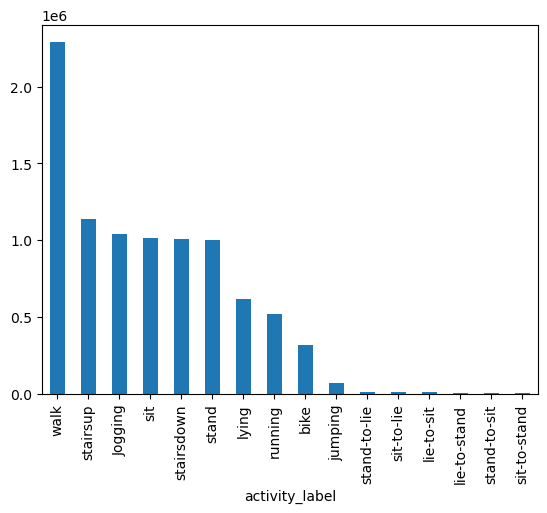

In [73]:
# label dictionary
label_dict = {
        1: 'bike',
        2: 'sit',
        3: 'stand',
        4: 'walk',
        5: 'stairsup',
        6: 'stairsdown',
        7: 'jumping',
        8: 'lying',
        9: 'running',
        10: 'Jogging',
        11: 'stand-to-sit',
        12: 'sit-to-stand',
        13: 'sit-to-lie',
        14: 'lie-to-sit',
        15: 'stand-to-lie',
        16: 'lie-to-stand',
}

# visualize the label distribution using label dictionary
data['activity_label'] = data['activity'].map(label_dict)
data['activity_label'].value_counts().plot(kind='bar')

<Axes: xlabel='subject_id'>

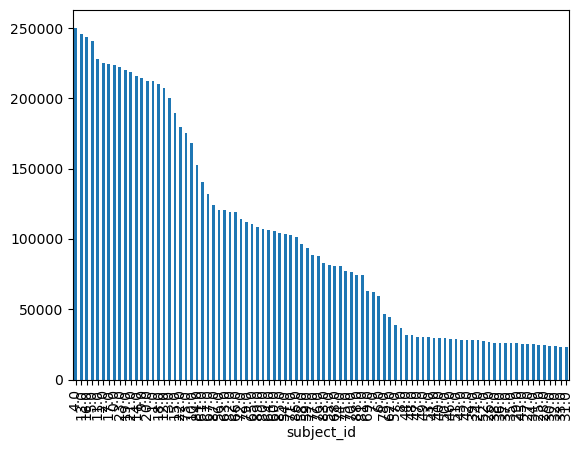

In [74]:
# visualize the subject distribution
data['subject_id'].value_counts().plot(kind='bar')

In [75]:
#drop activity_label
data = data.drop(columns=['activity_label'])

In [76]:
data

,subject_id,acc_x,acc_y,acc_z,activity
0,6.0,4.018668,-7.155670,-3.341109,3.0
1,6.0,3.038841,-6.546346,-3.436278,3.0
2,6.0,3.354875,-6.126762,-2.382231,3.0
3,6.0,2.688689,-5.518635,-1.930924,3.0
4,6.0,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
9094842,89.0,-1.927500,8.960000,2.533385,3.0
9094843,89.0,-2.070000,8.770000,2.179256,3.0
9094844,89.0,-2.093333,9.143333,2.179256,3.0
9094845,89.0,-2.116667,9.516667,2.179256,3.0


### Remove Uncommon Label

In [77]:
# remove rows with uncommon activities
data = data[data['activity'] != 16]
data = data[data['activity'] != 11]
data = data[data['activity'] != 12]
data = data[data['activity'] != 13]
data = data[data['activity'] != 14]
data = data[data['activity'] != 15]

data

,subject_id,acc_x,acc_y,acc_z,activity
0,6.0,4.018668,-7.155670,-3.341109,3.0
1,6.0,3.038841,-6.546346,-3.436278,3.0
2,6.0,3.354875,-6.126762,-2.382231,3.0
3,6.0,2.688689,-5.518635,-1.930924,3.0
4,6.0,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
9094842,89.0,-1.927500,8.960000,2.533385,3.0
9094843,89.0,-2.070000,8.770000,2.179256,3.0
9094844,89.0,-2.093333,9.143333,2.179256,3.0
9094845,89.0,-2.116667,9.516667,2.179256,3.0


<Axes: xlabel='subject_id'>

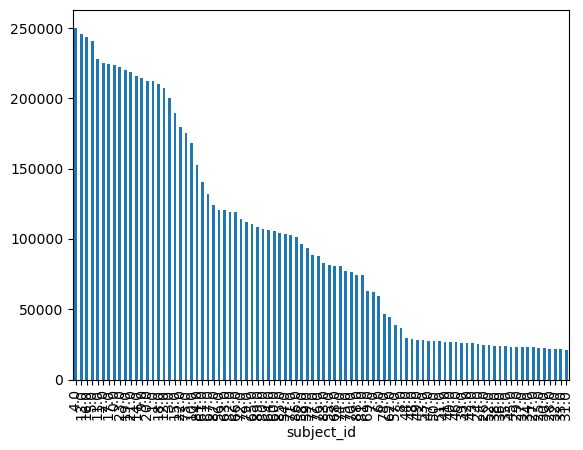

In [78]:
# visualize the subject distribution
data['subject_id'].value_counts().plot(kind='bar')

<Axes: xlabel='activity_label'>

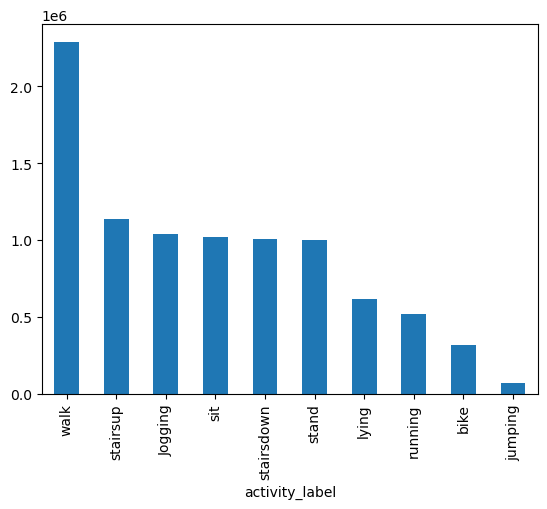

In [79]:
# label dictionary
label_dict = {
        1: 'bike',
        2: 'sit',
        3: 'stand',
        4: 'walk',
        5: 'stairsup',
        6: 'stairsdown',
        7: 'jumping',
        8: 'lying',
        9: 'running',
        10: 'Jogging',
        11: 'stand-to-sit',
        12: 'sit-to-stand',
        13: 'sit-to-lie',
        14: 'lie-to-sit',
        15: 'stand-to-lie',
        16: 'lie-to-stand',
}

# visualize the label distribution using label dictionary
data['activity_label'] = data['activity'].map(label_dict)
data['activity_label'].value_counts().plot(kind='bar')

In [80]:
#drop activity_label
data = data.drop(columns=['activity_label'])

In [81]:
# check for unique activities
print(data['activity'].nunique())

10


In [82]:
np.sort(data['activity'].unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [83]:
data['activity'] = data['activity'] - 1

In [84]:
# check for unique subjects
print(data['subject_id'].nunique())

90


In [85]:
data

,subject_id,acc_x,acc_y,acc_z,activity
0,6.0,4.018668,-7.155670,-3.341109,2.0
1,6.0,3.038841,-6.546346,-3.436278,2.0
2,6.0,3.354875,-6.126762,-2.382231,2.0
3,6.0,2.688689,-5.518635,-1.930924,2.0
4,6.0,0.672172,-4.964377,-1.953669,2.0
...,...,...,...,...,...
9094842,89.0,-1.927500,8.960000,2.533385,2.0
9094843,89.0,-2.070000,8.770000,2.179256,2.0
9094844,89.0,-2.093333,9.143333,2.179256,2.0
9094845,89.0,-2.116667,9.516667,2.179256,2.0


In [86]:
data['activity'].unique()

array([2., 1., 3., 5., 4., 0., 8., 6., 7., 9.])

In [87]:
data

,subject_id,acc_x,acc_y,acc_z,activity
0,6.0,4.018668,-7.155670,-3.341109,2.0
1,6.0,3.038841,-6.546346,-3.436278,2.0
2,6.0,3.354875,-6.126762,-2.382231,2.0
3,6.0,2.688689,-5.518635,-1.930924,2.0
4,6.0,0.672172,-4.964377,-1.953669,2.0
...,...,...,...,...,...
9094842,89.0,-1.927500,8.960000,2.533385,2.0
9094843,89.0,-2.070000,8.770000,2.179256,2.0
9094844,89.0,-2.093333,9.143333,2.179256,2.0
9094845,89.0,-2.116667,9.516667,2.179256,2.0


In [88]:
# check the null values
data.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [89]:
# check the data types per columns
data.dtypes

subject_id    float64
acc_x         float64
acc_y         float64
acc_z         float64
activity      float64
dtype: object

In [90]:
# z-normalization of acc_x, acc_y, and acc_z
data['acc_x'] = (data['acc_x'] - data['acc_x'].mean()) / data['acc_x'].std()
data['acc_y'] = (data['acc_y'] - data['acc_y'].mean()) / data['acc_y'].std()
data['acc_z'] = (data['acc_z'] - data['acc_z'].mean()) / data['acc_z'].std()

## Partitioned the Data for Train and Test

In [91]:
# disabiling the warnings
import warnings
warnings.filterwarnings("ignore")

In [92]:
# data_test = {}
# data_labelled_train = {}
# data_unlabelled_train = {}

# #split the data for each subject
# for subject in np.sort(data['subject_id'].unique()):
#     subject_data = data[data['subject_id'] == subject]
#     # Shuffle the subject data
#     subject_data = subject_data.sample(frac=1).reset_index(drop=True)

#     # drop the subject_id column
#     subject_data = subject_data.drop(columns=['subject_id'])

#     # Split the subject data into 80% training and 20% testing
#     train, test = np.split(subject_data, [int(0.8 * len(subject_data))])

#     # Within the train data, further split into 20% labelled and 80% unlabelled
#     labelled_train, unlabelled_train = np.split(train, [int(0.2 * len(train))])

#     data_test[subject] = test
#     data_labelled_train[subject] = labelled_train
#     data_unlabelled_train[subject] = unlabelled_train

# # verify the split
# for subject in np.sort(data['subject_id'].unique()):
#     print('Subject:', subject)
#     print('Test:', data_test[subject].shape)
#     print('Labelled Train:', data_labelled_train[subject].shape)
#     print('Unlabelled Train:', data_unlabelled_train[subject].shape)

In [93]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

data_test = {}
data_labelled_train = {}
data_unlabelled_train = {}

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for subject in np.sort(data['subject_id'].unique()):
    subject_data = data[data['subject_id'] == subject]
    labels = subject_data['activity'].values  # Assuming 'label' is your class label column

    # Drop the subject_id column
    subject_data = subject_data.drop(columns=['subject_id'])
    
    # Perform stratified split for train and test
    for train_index, test_index in sss.split(subject_data, labels):
        train_data, test_data = subject_data.iloc[train_index], subject_data.iloc[test_index]
        train_labels = labels[train_index]
        
        # Further split train data into labelled and unlabelled in a stratified manner
        sss_inner = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=42)
        for labelled_index, unlabelled_index in sss_inner.split(train_data, train_labels):
            labelled_train_data, unlabelled_train_data = train_data.iloc[labelled_index], train_data.iloc[unlabelled_index]
    
    # Store splits
    data_test[subject] = test_data
    data_labelled_train[subject] = labelled_train_data
    data_unlabelled_train[subject] = unlabelled_train_data

# Verify the split
for subject in np.sort(data['subject_id'].unique()):
    print('Subject:', subject)
    print('Test:', data_test[subject].shape)
    print('Labelled Train:', data_labelled_train[subject].shape)
    print('Unlabelled Train:', data_unlabelled_train[subject].shape)

Subject: 0.0
Test: (44756, 4)
Labelled Train: (35804, 4)
Unlabelled Train: (143218, 4)
Subject: 1.0
Test: (42456, 4)
Labelled Train: (33964, 4)
Unlabelled Train: (135860, 4)
Subject: 2.0
Test: (44994, 4)
Labelled Train: (35995, 4)
Unlabelled Train: (143980, 4)
Subject: 3.0
Test: (40035, 4)
Labelled Train: (32027, 4)
Unlabelled Train: (128110, 4)
Subject: 4.0
Test: (50062, 4)
Labelled Train: (40049, 4)
Unlabelled Train: (160197, 4)
Subject: 5.0
Test: (48110, 4)
Labelled Train: (38487, 4)
Unlabelled Train: (153950, 4)
Subject: 6.0
Test: (11824, 4)
Labelled Train: (9458, 4)
Unlabelled Train: (37834, 4)
Subject: 7.0
Test: (12480, 4)
Labelled Train: (9983, 4)
Unlabelled Train: (39936, 4)
Subject: 8.0
Test: (7336, 4)
Labelled Train: (5868, 4)
Unlabelled Train: (23473, 4)
Subject: 9.0
Test: (42932, 4)
Labelled Train: (34345, 4)
Unlabelled Train: (137382, 4)
Subject: 10.0
Test: (33713, 4)
Labelled Train: (26970, 4)
Unlabelled Train: (107882, 4)
Subject: 11.0
Test: (45565, 4)
Labelled Train: (3

## Windowing the Data

In [94]:
def sliding_window_samples(data, samples_per_window, overlap_ratio):
    """
    Return a sliding window measured in number of samples over a data array along with the mode label for each window.

    :param data: input array, can be numpy or pandas dataframe
    :param samples_per_window: window length as number of samples
    :param overlap_ratio: overlap is meant as percentage and should be an integer value
    :return: tuple of windows, indices, and labels
    """
    windows = []
    indices = []
    labels = []
    curr = 0
    win_len = int(samples_per_window)
    if overlap_ratio is not None:
        overlapping_elements = int((overlap_ratio / 100) * win_len)
        if overlapping_elements >= win_len:
            print('Number of overlapping elements exceeds window size.')
            return
    while curr < len(data) - win_len:
        window = data[curr:curr + win_len]
        windows.append(window.iloc[:, :-1])  # Exclude the last column which is the label
        indices.append([curr, curr + win_len])
        
        # Extract and compute the mode of the encoded labels for the current window
        window_labels = window['activity']
        mode_result = mode(window_labels)
        window_label = mode_result[0] if mode_result[0].size > 0 else mode_result
        labels.append(window_label)

        curr += win_len - overlapping_elements

    result_windows = np.array(windows)
    result_indices = np.array(indices)
    result_labels = np.array(labels)
    return result_windows, result_indices, result_labels

In [95]:
# windowing the data for each subject
sampling_rate = 50
time_window = 2.56
window_size = sampling_rate * time_window
overlap_ratio = 50 # 50% overlap

print('Window size:', window_size)
print('Overlap ratio %:', overlap_ratio)

windowed_labelled_train_x = []
windowed_unlabelled_train_x = []
windowed_test_x = []
windowed_labelled_train_y = []
windowed_unlabelled_train_y = []
windowed_test_y = []

# Iterate over each client and apply the sliding window
for subject in np.sort(data['subject_id'].unique()):
    labelled_train_data = data_labelled_train[subject]
    unlabelled_train_data = data_unlabelled_train[subject]
    test_data = data_test[subject]

    labelled_train_windows, _, labelled_train_labels = sliding_window_samples(labelled_train_data, window_size, overlap_ratio)
    unlabelled_train_windows, _, unlabelled_train_labels = sliding_window_samples(unlabelled_train_data, window_size, overlap_ratio)
    test_windows, _, test_labels = sliding_window_samples(test_data, window_size, overlap_ratio)

    windowed_labelled_train_x.append(labelled_train_windows)
    windowed_unlabelled_train_x.append(unlabelled_train_windows)
    windowed_test_x.append(test_windows)

    windowed_labelled_train_y.append(labelled_train_labels)
    windowed_unlabelled_train_y.append(unlabelled_train_labels)
    windowed_test_y.append(test_labels)

    print('Subject:', subject, 'Labelled Train Data shape:', labelled_train_windows.shape, 'Labelled Train Labels shape:', labelled_train_labels.shape)
    print('Subject:', subject, 'Unlabelled Train Data shape:', unlabelled_train_windows.shape, 'Unlabelled Train Labels shape:', unlabelled_train_labels.shape)
    print('Subject:', subject, 'Test Data shape:', test_windows.shape, 'Test Labels shape:', test_labels.shape)

Window size: 128.0
Overlap ratio %: 50


Subject: 0.0 Labelled Train Data shape: (558, 128, 3) Labelled Train Labels shape: (558,)
Subject: 0.0 Unlabelled Train Data shape: (2236, 128, 3) Unlabelled Train Labels shape: (2236,)
Subject: 0.0 Test Data shape: (698, 128, 3) Test Labels shape: (698,)
Subject: 1.0 Labelled Train Data shape: (529, 128, 3) Labelled Train Labels shape: (529,)
Subject: 1.0 Unlabelled Train Data shape: (2121, 128, 3) Unlabelled Train Labels shape: (2121,)
Subject: 1.0 Test Data shape: (662, 128, 3) Test Labels shape: (662,)
Subject: 2.0 Labelled Train Data shape: (561, 128, 3) Labelled Train Labels shape: (561,)
Subject: 2.0 Unlabelled Train Data shape: (2248, 128, 3) Unlabelled Train Labels shape: (2248,)
Subject: 2.0 Test Data shape: (702, 128, 3) Test Labels shape: (702,)
Subject: 3.0 Labelled Train Data shape: (499, 128, 3) Labelled Train Labels shape: (499,)
Subject: 3.0 Unlabelled Train Data shape: (2000, 128, 3) Unlabelled Train Labels shape: (2000,)
Subject: 3.0 Test Data shape: (624, 128, 3) Te

In [96]:
windowed_labelled_train_x[0]

array([[[-1.89596905, -0.64855733, -1.16311659],
        [-1.16780298,  0.12845467, -0.25345934],
        [-0.9842358 , -0.75123725,  0.25282631],
        ...,
        [-0.91498569, -0.8680535 ,  0.34531672],
        [-1.12239506, -0.58399215, -0.17784985],
        [-1.1322879 , -0.61303663, -0.41616868]],

       [[-0.69802464, -0.38419172, -0.01102666],
        [-1.22507621,  0.00328068, -0.18068698],
        [-0.33130589, -0.54696842,  1.15446591],
        ...,
        [-0.8846248 , -0.58622633,  1.18737658],
        [-0.89451771, -0.35482807,  1.19815768],
        [-0.99549332, -0.35642393,  1.15843787]],

       [[-0.48208697, -1.73619591, -2.01687678],
        [-1.12171275, -0.55622436,  0.01734461],
        [-1.10874969, -0.56516112, -0.25218263],
        ...,
        [-0.65674745, -0.38993678, -0.38439283],
        [-0.83349195,  0.4868826 ,  0.75485629],
        [-1.6521757 , -0.69059493, -0.18238926]],

       ...,

       [[-0.82441835, -0.88539318,  0.33888287],
        [-0

In [97]:
windowed_labelled_train_y[0]

array([3., 2., 2., 1., 0., 2., 2., 3., 2., 2., 3., 3., 3., 2., 2., 2., 2.,
       0., 2., 2., 3., 2., 2., 2., 3., 3., 0., 0., 0., 3., 2., 2., 2., 2.,
       2., 2., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 3., 2., 2., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 2., 0., 2., 2., 2., 0., 2., 2., 2., 3., 3., 2., 2., 0.,
       0., 3., 3., 2., 2., 3., 0., 2., 2., 2., 2., 0., 0., 3., 1., 3., 3.,
       3., 3., 0., 2., 2., 3., 3., 2., 3., 0., 2., 2., 2., 1., 0., 3., 2.,
       2., 3., 3., 2., 2., 2., 3., 3., 3., 0., 3., 2., 2., 2., 2., 2., 2.,
       4., 0., 0., 2., 0., 0., 2., 2., 2., 1., 2., 0., 0., 2., 2., 2., 2.,
       0., 0., 1., 3., 3., 3., 2., 0., 2., 2., 1., 0., 0., 2., 2., 2., 0.,
       0., 2., 2., 2., 3., 3., 2., 2., 2., 0., 0., 2., 2., 2., 2., 2., 2.,
       0., 0., 3., 2., 2., 0., 0., 0., 0., 2., 3., 0., 0., 0., 2., 2., 0.,
       0., 0., 2., 2., 2., 2., 2., 2., 3., 3., 3., 2., 1., 2., 2., 2., 3.,
       2., 3., 3., 2., 2.

In [98]:
# windowed_data_test = []
# windowed_labels_test = []
# windowed_data_labelled_train = []
# windowed_labels_labelled_train = []
# windowed_data_unlabelled_train = []
# windowed_labels_unlabelled_train = []

# # randomly split data into test and train for each subject
# for i in range(len(windowed_data)):
#     subject_windows = windowed_data[i]
#     subject_labels = windowed_labels[i]

#     # number of samples
#     n_samples = subject_windows.shape[0]

#     # generate indices for the whole dataset
#     indices = np.arange(n_samples)

#     # randomly shuffle the indices
#     np.random.shuffle(indices)

#     # Split indices for training (80%) and testing (20%)
#     train_indices = indices[:int(0.8 * n_samples)]
#     test_indices = indices[int(0.8 * n_samples):]

#     # Split the data into training and testing sets
#     x_train, y_train = subject_windows[train_indices], subject_labels[train_indices]
#     x_test, y_test = subject_windows[test_indices], subject_labels[test_indices]

#     # Split the training data into labelled and unlabelled sets (20% labelled, 80% unlabelled)
#     n_train_samples = x_train.shape[0]
#     n_labelled_samples = int(0.2 * n_train_samples)
#     labelled_indices = np.random.choice(n_train_samples, n_labelled_samples, replace=False)
#     unlabelled_indices = np.array([i for i in range(n_train_samples) if i not in labelled_indices])

#     x_labelled_train, y_labelled_train = x_train[labelled_indices], y_train[labelled_indices]
#     x_unlabelled_train, y_unlabelled_train = x_train[unlabelled_indices], y_train[unlabelled_indices]

#     windowed_data_test.append(x_test)
#     windowed_labels_test.append(y_test)
#     windowed_data_labelled_train.append(x_labelled_train)
#     windowed_labels_labelled_train.append(y_labelled_train)
#     windowed_data_unlabelled_train.append(x_unlabelled_train)
#     windowed_labels_unlabelled_train.append(y_unlabelled_train)

#     # print the shapes of the data
#     print('Subject:', i, 'Original Data:', subject_windows.shape, 'Original Label:', len(subject_labels))
#     print('Subject:', i, 'Train data shape:', x_train.shape, 'Test data shape:', x_test.shape)
#     print('Subject:', i, 'Labelled Train data shape:', x_labelled_train.shape, 'Unlabelled Train data shape:', x_unlabelled_train.shape)
#     print('*' * 50)


# Saved the FL Data

In [101]:
# save all data to local directory with the data for each subject in one folder

# create a directory to save the data
if not os.path.exists('FL_Data/windowed_data_filtered_v5'):
    os.makedirs('FL_Data/windowed_data_filtered_v5')

# save the data
for i in range(len(windowed_labelled_train_x)):
    subject = i
    subject_dir = 'FL_Data/windowed_data_filtered_v5/subject_' + str(subject)
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    np.save(subject_dir + '/windowed_labelled_train_x.npy', windowed_labelled_train_x[i])
    np.save(subject_dir + '/windowed_unlabelled_train_x.npy', windowed_unlabelled_train_x[i])
    np.save(subject_dir + '/windowed_test_x.npy', windowed_test_x[i])
    np.save(subject_dir + '/windowed_labelled_train_y.npy', windowed_labelled_train_y[i])
    np.save(subject_dir + '/windowed_unlabelled_train_y.npy', windowed_unlabelled_train_y[i])
    np.save(subject_dir + '/windowed_test_y.npy', windowed_test_y[i])

In [102]:
# validate the saved data for each subject and check whether the shapes are correct with the original data
# compare the shape load data with the array of original data
for i in range(len(windowed_labelled_train_x)):
    subject = i
    subject_dir = 'FL_Data/windowed_data_filtered_v5/subject_' + str(subject)
    print('Subject:', subject)
    print('Labelled Train Data:', np.array_equal(windowed_labelled_train_x[i], np.load(subject_dir + '/windowed_labelled_train_x.npy')))
    print('Unlabelled Train Data:', np.array_equal(windowed_unlabelled_train_x[i], np.load(subject_dir + '/windowed_unlabelled_train_x.npy')))
    print('Test Data:', np.array_equal(windowed_test_x[i], np.load(subject_dir + '/windowed_test_x.npy')))
    print('Labelled Train Labels:', np.array_equal(windowed_labelled_train_y[i], np.load(subject_dir + '/windowed_labelled_train_y.npy')))
    print('Unlabelled Train Labels:', np.array_equal(windowed_unlabelled_train_y[i], np.load(subject_dir + '/windowed_unlabelled_train_y.npy')))
    print('Test Labels:', np.array_equal(windowed_test_y[i], np.load(subject_dir + '/windowed_test_y.npy')))
    print('*' * 50)

Subject: 0
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 1
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 2
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 3
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 4
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
***********